# Tarifes AMB: Desplaçament unipersonal

Avui s'han fet públiques les tarifes del transport públic a l'Àrea Metropolitana de Barcelona (AMB) pel 2020. Aquestes tarifes aposten per títols unipersonals i per un us habitual i regular del **transport públic** (a diferència d'apostar per mètodes de transport sostenibles).

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
xr.set_options(display_style="html");

import arviz as az

In [2]:
az.style.use("arviz-darkgrid")

In [3]:
preus_2019 = xr.load_dataarray("preus_atm.nc", group="2019")

In [4]:
preus_2020 = xr.load_dataarray("preus_atm.nc", group="2020")

In [5]:
tipus_bitllets = {
    "senzill": 1,
    "t-10": 10,
    "t-casual": 10,
    "t-mes": "mensual",
    "t-usual": "mensual",
    "t-70/30": 70,
    "t-grup": 70,
    "t-jove": "trimestral",
    "t-trimestre": "trimestral"
}
def preu_per_mes(
    n_viatges, bitllet="senzill", zones=1, tarifa=2019, bonificacio="cap"
):
    """Calcula el preu mensual segons el nombre de viatges.
    
    Parameters
    ----------
    n_viatges: int or array-like
        Nombre de viatges al mes
    bitllet: str, opcional
        Tipus de bitllet
    zones: int, opcional
        Nombre de zones del bitllet
    tarifa: int, opcional
        Utilitzar les tarifes vigents l'any ``tarifa``
    bonificacio: str, opcional
        Quina bonificació cal utilitzar per fer el calcul
    
    Returns
    -------
    int
        Preu mensual en euros
    """
    n_viatges = np.asarray(n_viatges)
    bitllet = bitllet.lower()
    if tarifa == 2019:
        data = preus_2019
    elif tarifa == 2020:
        data = preus_2020
    else:
        raise ValueError("No hi ha dades de l'any {}".format(tarifa))
    tipus_bitllet = tipus_bitllets[bitllet]
    preu = data.sel(
            bitllet=bitllet, zona=zones, bonificacio=bonificacio
        ).values
    if tipus_bitllet == "mensual":
        return np.full_like(n_viatges, preu)
    if tipus_bitllet == "trimestral":
        return np.full_like(n_viatges, preu / 3)
    bitllets, extra = np.divmod(n_viatges, tipus_bitllet)
    return (bitllets + np.array(extra != 0, dtype=np.int)) * preu

In [6]:
def compara_bitllets(bitllets, ax, viatges=None, legend_title=None, plot_kwargs=None, **kwargs):
    """Compara diferents bitllets segons el preu mensual.
    
    Parameters
    ----------
    bitllets: array-like
    ax: matplotlib axes
    viatges: array-like
    kwargs: mapping
        Els kwargs es passen directament a ``preu_per_mes``
    """
    if viatges is None:
        viatges = np.arange(1, 40)
    for i, bitllet in enumerate(bitllets):
        if plot_kwargs is None:
            un_plot_kwargs = {}
        elif isinstance(plot_kwargs, list):
            un_plot_kwargs = plot_kwargs[i]
        else:
            un_plot_kwargs = {**plot_kwargs}
        un_plot_kwargs.setdefault("label", bitllet)
        un_plot_kwargs.setdefault("drawstyle", "steps-post")
        ax.plot(
            viatges, 
            preu_per_mes(viatges, bitllet=bitllet, **kwargs), 
            **un_plot_kwargs
        )
    ax.set_ylim(bottom=0)   
    ax.legend(loc="lower right", title=legend_title)
    return ax

def preu_minim(bitllets, ax, viatges=None, plot_kwargs=None, **kwargs):
    if viatges is None:
        viatges = np.arange(1, 40)
    if plot_kwargs is None:
        plot_kwargs = {}
    plot_kwargs.setdefault("drawstyle", "steps-post")
    preu_per_viatge = np.full_like(viatges, np.infty, dtype=np.float)
    for bitllet in bitllets:
        preu_bitllet = preu_per_mes(viatges, bitllet=bitllet, **kwargs)
        mask = preu_bitllet < preu_per_viatge
        preu_per_viatge[mask] = preu_bitllet[mask]
    ax.plot(viatges, preu_per_viatge, **plot_kwargs)

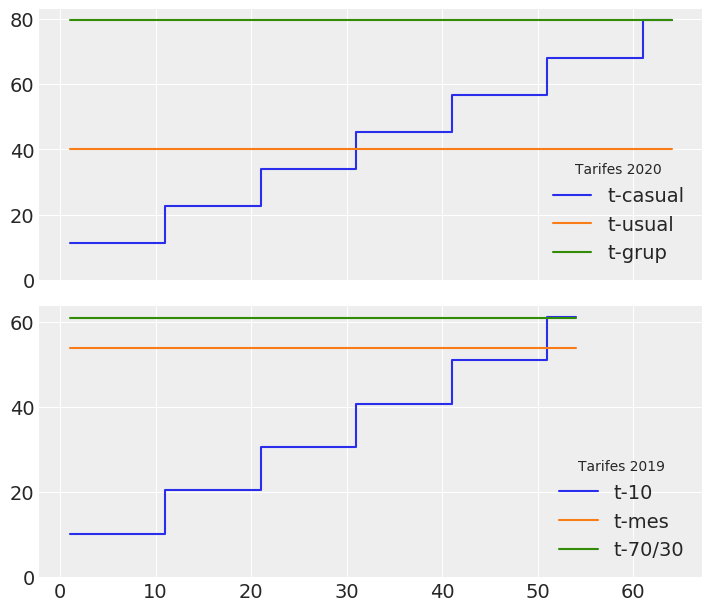

In [7]:
_, ax = plt.subplots(
    2, 1, figsize=(7, 6), sharex=True, constrained_layout=True
)
bitllets_2019 = ["t-10", "t-mes", "t-70/30"]
bitllets_2020 = ["t-casual", "t-usual", "t-grup"]
compara_bitllets(
    bitllets_2020, 
    ax[0], 
    tarifa=2020, 
    viatges=np.arange(1,65),
    legend_title="Tarifes 2020"
)
compara_bitllets(
    bitllets_2019, 
    ax[1], 
    tarifa=2019, 
    viatges=np.arange(1,55),
    legend_title="Tarifes 2019"
);

En el cas de viatgers habituals l'estalvi és substancial, amb les tarifes del 2019 comprar 5 T-10 al mes sortia més a compte que comprar una T-Mes. Per contra, amb les noves tarifes del 2020, comprar més de 3 T-10 (T-Casual) al mes ja no surt a compte.

Tanmateix, també és important notar, que tal com es pot veure aquí, en cap cas surt a compte la T-70/30 (que es dirà T-grup a partir d'ara) a l'hora de fer desplçaments unipersonals, l'únic cas en que té sentit comprar una T-70/30 és si es viatja en grup.

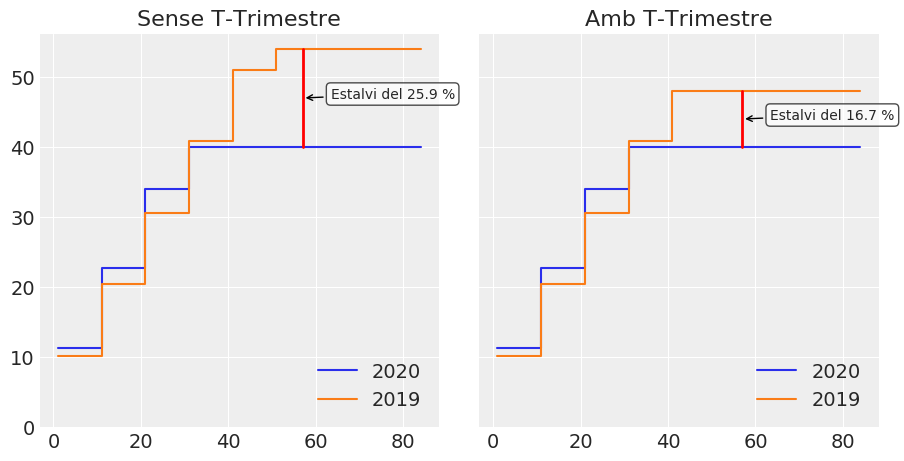

In [8]:
viatges=np.arange(1,85)
_, ax = plt.subplots(1, 2, figsize=(9, 4.5), sharey=True, constrained_layout=True)
bitllets_2019 = ["t-10", "t-mes", "t-70/30"]
bitllets_2020 = ["t-casual", "t-usual", "t-grup"]
titles = ["Sense T-Trimestre", "Amb T-Trimestre"]
vline = 57
for i in range(2):
    preu_minim(
        bitllets_2020, 
        ax[i], 
        tarifa=2020, 
        viatges=viatges,
        plot_kwargs={"label": "2020"}
    )
    preu_minim(
        bitllets_2019, 
        ax[i], 
        tarifa=2019, 
        viatges=viatges,
        plot_kwargs={"label": "2019"}
    );
    ax[i].legend(loc="lower right")
    ax[i].grid(True)
    ax[i].set_ylim(bottom=0)
    ax[i].set_title(titles[i])
    preu_2019 = np.min([preu_per_mes(vline, bitllet=bitllet, tarifa=2019) for bitllet in bitllets_2019])
    preu_2020 = np.min([preu_per_mes(vline, bitllet=bitllet, tarifa=2020) for bitllet in bitllets_2020])
    estalvi = (preu_2019 - preu_2020) / preu_2019 * 100
    ax[i].plot([vline, vline], [preu_2020, preu_2019], color="r", lw=2)
    ax[i].annotate(
        "Estalvi del {:.1f} %".format(estalvi),
        xy=(vline, (preu_2019 + preu_2020)/2),
        xytext=(20, 0),
        textcoords="offset points",
        bbox=dict(boxstyle="round", fc="w", alpha=.7),
        arrowprops=dict(arrowstyle="->"),
        ha="left"
    )
    bitllets_2019.append("t-trimestre")